Make sure that you use the right database to produce the statistics
Number of programs that are our targets: 272
Number of programs that built successfully by ABC: 264
Number of programs that speedup by ABC(larger than twice sigma): 136
(Arithmetic mean)Average speedup of all the ABC built programs is: 1.0246683293554752
(Arithmetic mean)Average speedup of all the ABC built programs is(> 2*sigma): 1.0407196334568303
(Geometic mean)Average speedup of all the ABC built programs is: 1.0237008343696616
(Geometic mean)Average speedup of all the ABC built programs is(> 2*sigma): 1.0391634937289842
Numbers of speedup programs: 214, and slowdown: 50
Numbers of speedup programs(larger than twice sigma): 113, and slowdown: 23
(Num of Speedup) / (Number of All) = 0.8106060606060606
(Num of Speedup) / (Number of All) = (larger than twice sigma)0.8308823529411765
Make sure that you use the right database to produce the statistics


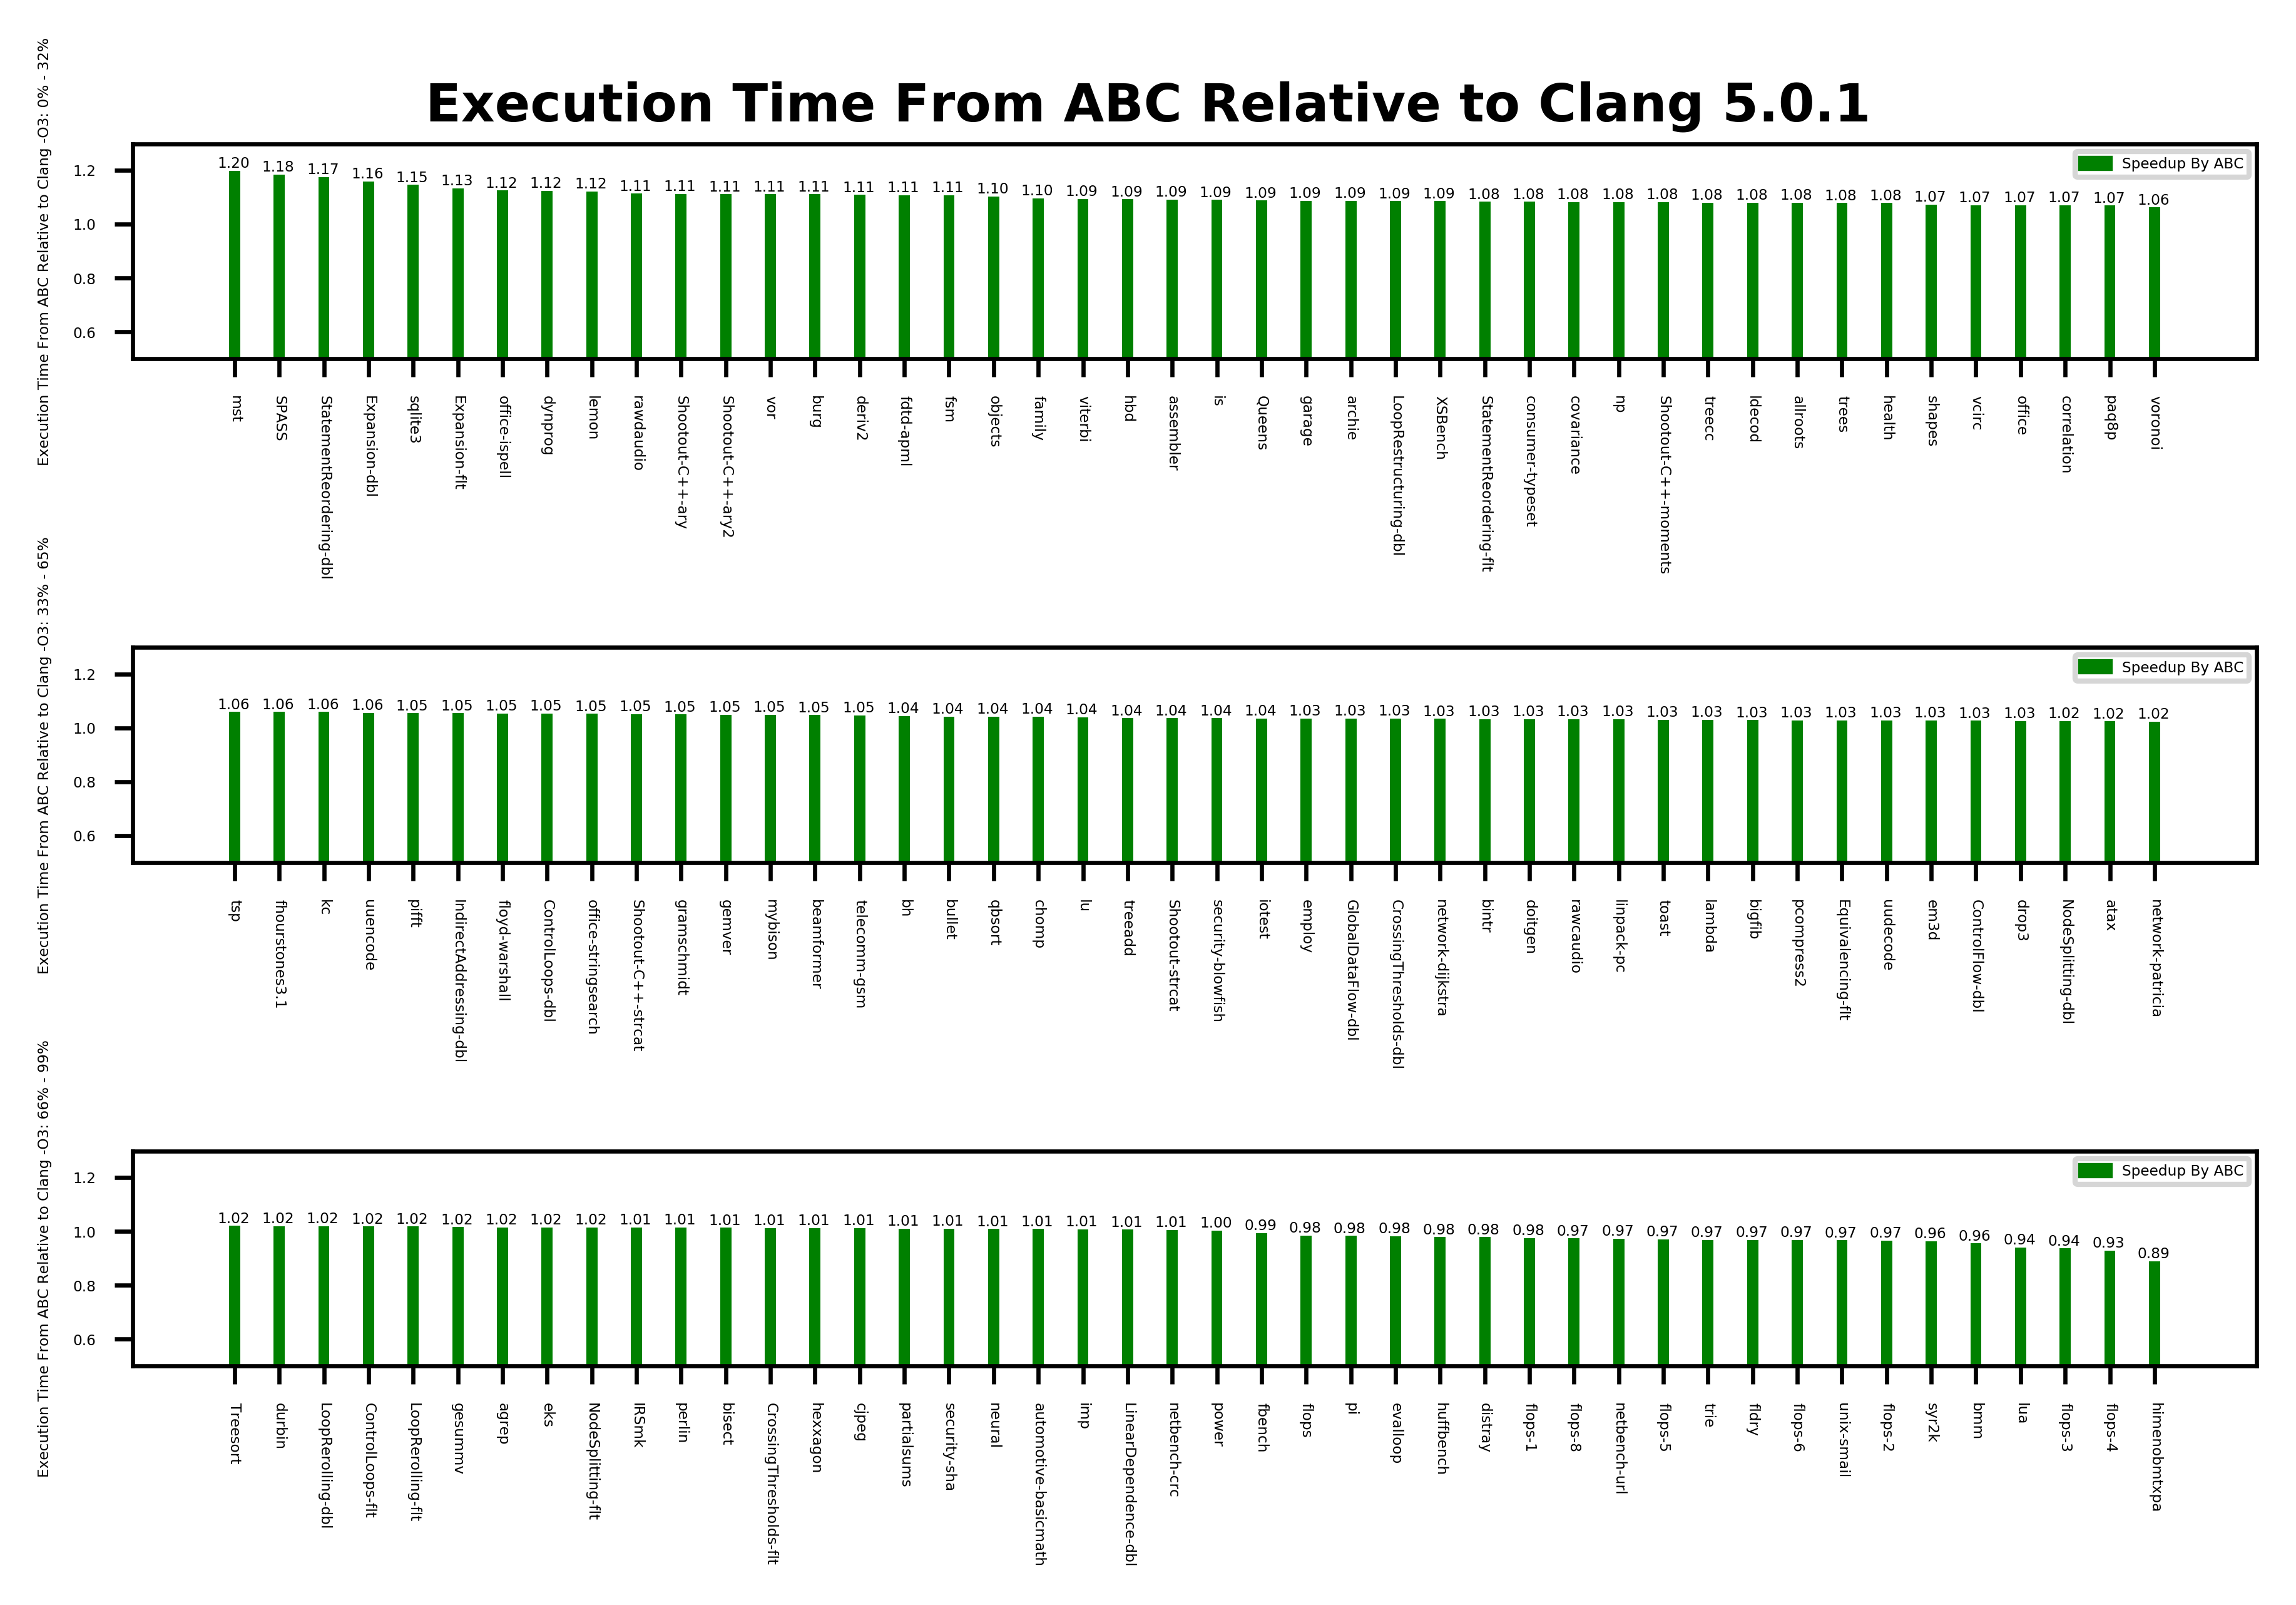

[['mst', 1.1978356360223585], ['SPASS', 1.1843190333057483], ['StatementReordering-dbl', 1.174770496861045], ['Expansion-dbl', 1.1593104717788154], ['sqlite3', 1.1454978183493358], ['Expansion-flt', 1.1336493992115173], ['office-ispell', 1.1245300281129034], ['dynprog', 1.1240361785406734], ['lemon', 1.12216981504481], ['rawdaudio', 1.1131792315343867], ['Shootout-C++-ary', 1.1116004392643943], ['Shootout-C++-ary2', 1.111097281765557], ['vor', 1.1107463989534179], ['burg', 1.110662492969113], ['deriv2', 1.1087883440593251], ['fdtd-apml', 1.1078460869274516], ['fsm', 1.107767465555565], ['objects', 1.1024836436616543], ['family', 1.0956054048595494], ['viterbi', 1.0931925008687036], ['hbd', 1.0922044946531995], ['assembler', 1.0907661913760522], ['is', 1.090006676598935], ['Queens', 1.0873263933791784], ['garage', 1.087114608042539], ['archie', 1.0859983735096899], ['LoopRestructuring-dbl', 1.085534771649655], ['XSBench', 1.0851554573713498], ['StatementReordering-flt', 1.08361390681967

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from operator import itemgetter
import copy
import operator
import functools

%matplotlib inline 

def GeoMean(iterable):
    power = 1.0 / len(iterable)
    return functools.reduce(operator.mul, iterable) ** power

def GraphGenerator_AutoLabel(rects, ax, location):
    """
    Helper function
    """
    horizontalAlign = 'center'
    if location == "up":
        verticalAlign='bottom'
    else:
        verticalAlign='top'

    for rect in rects:
        h = rect.get_height()
        label = "%.2f" % (h)
        if location == "up":
            h = h*1.0
        else:
            h = h*1.0
        ax.text(rect.get_x()+0.1, h, label,
                ha=horizontalAlign, va=verticalAlign)

def DrawBarChart(Inputs, Title, Ymax = None, Ymin = None):
    """
    Draw the bar chart
    """
    '''
    Prepare chart input
    '''
    NameList = []
    Speedup = []
    for item in Inputs:
        NameList.append(item[0])
        Speedup.append(item[1])

    x = NameList
    y = Speedup
    '''
    Draw bar chart
    '''
    plt.rc('font', size=2.8)
    fig = plt.figure(dpi=600)
    width = 0.25 # the width of the bars

    # Split into N bar chart
    splitCount = 3
    step = len(x) // splitCount
    patch_speedup = mpatches.Patch(color='green', label='Speedup By ABC')
    percentage = 0.33

    for i in range(splitCount):
        indexStart = i*step
        indexEnd = indexStart + int(percentage * len(x))

        x_sub = x[indexStart:indexEnd]
        y_sub = y[indexStart:indexEnd]
        #x_sub_order = [x for x in range(indexStart, indexEnd)]
        index = np.arange(len(x_sub))
        ax = fig.add_subplot(splitCount, 1 , i+1)

        rects = ax.bar(index, y_sub, width, color='green')
        # Do we need to limit the y axis?
        if Ymin == None and Ymax != None:
            plt.ylim(ymax=Ymax)
        elif Ymin != None and Ymax == None:
            plt.ylim(ymin=Ymin)
        elif Ymin != None and Ymax != None:
            plt.ylim(ymin=Ymin, ymax=Ymax)

        y_label_loc = "up"
        GraphGenerator_AutoLabel(rects, ax, y_label_loc)

        XLength = len(x)
        ax.set_ylabel('Execution Time From ABC Relative to Clang -O3: {}% - {}%'.format(
            round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
        
        ax.set_xticks(index)
        ax.set_xticklabels(x_sub, rotation=270)
        plt.legend( handles=[patch_speedup] )

    
    fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.0)
    plt.tight_layout()
    plt.show()
    fig.savefig(Title + ".png", dpi=fig.dpi, bbox_inches='tight')

        
if __name__ == '__main__':
    #TargetDir = "legacy_data/log-04-10_08-12"
    TargetDir = "legacy_data/log-04-03_21-20"
    #TargetDir = "legacy_data/log-03-31_16-53"
    ABC_cycles_mean = json.load(open(TargetDir + '/' + "ABC_cycles_mean.json"))
    Orig_cycles_mean = json.load(open("Orig_cycles_mean.json"))
    Orig_cycles_sigma = json.load(open("Orig_cycles_sigma.json"))
    # Due to not all the results are available(some may be -1, which indicating failure)
    AvailableKeys = []
    for target, cycles in ABC_cycles_mean.items():
        if cycles != -1:
            AvailableKeys.append(target)
    SpeedupDict = {}
    '''
    SpeedupDict contains all the information that we need =)
    speedup in the dict:
        > 0: speedup
        < 0: slowdown
    '''
    TotalSpeedup = 0.0
    TotalSpeedupCount = 0
    TotalSpeedupList = []
    LargerThanTwiceSigmaSpeedupList = []
    for target in AvailableKeys:
        new = ABC_cycles_mean[target]
        old = Orig_cycles_mean[target]
        speedup = old / new
        sigma = Orig_cycles_sigma[target]
        SpeedupDict[target] = {}
        SpeedupDict[target]['new'] = new
        SpeedupDict[target]['old'] = old
        SpeedupDict[target]['speedup'] = speedup
        TotalSpeedupList.append(speedup)
        SpeedupDict[target]['sigma'] = sigma
        if speedup > 1:
            TotalSpeedupCount += 1

    AvgSpeedupAll = sum(TotalSpeedupList) / len(TotalSpeedupList)
    '''
    Discard the speedup or slow-down less than twice sigma
    '''
    SelectedSpeedupDict = copy.deepcopy(SpeedupDict)
    TotalSpeedupCountLargerThanTwice = copy.deepcopy(TotalSpeedupCount)
    for target, info in SpeedupDict.items():
        if abs(info['new'] - info['old']) < 2*info['sigma']:
            SelectedSpeedupDict.pop(target, None)
            if SpeedupDict[target]['speedup'] > 1:
                TotalSpeedupCountLargerThanTwice -= 1
        else:
            LargerThanTwiceSigmaSpeedupList.append(info['speedup'])
    AvgSpeedupLargerThanTwice = sum(LargerThanTwiceSigmaSpeedupList) / len(LargerThanTwiceSigmaSpeedupList)
    print('=============================================================================')
    print('Make sure that you use the right database to produce the statistics')
    print('=============================================================================')
    print("Number of programs that are our targets: {}".format(len(Orig_cycles_mean)))
    print("Number of programs that built successfully by ABC: {}".format(len(SpeedupDict)))
    print("Number of programs that speedup by ABC(larger than twice sigma): {}".format(len(SelectedSpeedupDict)))
    print("(Arithmetic mean)Average speedup of all the ABC built programs is: {}".format(AvgSpeedupAll))
    print("(Arithmetic mean)Average speedup of all the ABC built programs is(> 2*sigma): {}".format(AvgSpeedupLargerThanTwice))
    print("(Geometic mean)Average speedup of all the ABC built programs is: {}".format(GeoMean(TotalSpeedupList)))
    print("(Geometic mean)Average speedup of all the ABC built programs is(> 2*sigma): {}".format(GeoMean(LargerThanTwiceSigmaSpeedupList)))
    print("Numbers of speedup programs: {}, and slowdown: {}".format(TotalSpeedupCount, len(SpeedupDict)-TotalSpeedupCount))
    print("Numbers of speedup programs(larger than twice sigma): {}, and slowdown: {}".format(
        TotalSpeedupCountLargerThanTwice, len(SelectedSpeedupDict)-TotalSpeedupCountLargerThanTwice))
    print("(Num of Speedup) / (Number of All) = {}".format(TotalSpeedupCount/ len(SpeedupDict)))
    print("(Num of Speedup) / (Number of All) = (larger than twice sigma){}".format(TotalSpeedupCountLargerThanTwice/ len(SelectedSpeedupDict)))
    print('=============================================================================')
    print('Make sure that you use the right database to produce the statistics')
    print('=============================================================================')
    
    GraphData = []
    for target, info in SelectedSpeedupDict.items():
        GraphData.append([target, info['speedup']] )
    '''
    Sort the data in descending order for plotting graph.
    '''
    GraphData.sort(key=itemgetter(1), reverse=True)
    DrawBarChart(Inputs=GraphData, Title="Execution Time From ABC Relative to Clang 5.0.1", Ymax = GraphData[0][1]+0.10, Ymin = 0.5)
    print(GraphData)
        
        
        
        
